In [4]:
import pandas as pd
import numpy as np

def get_time_series_for_window(start_date, end_date, station, dataframe):
    return dataframe.loc[start_date:end_date, [station]]


def check_nan_values(dataframe):
    return dataframe.isnull().values.any()


def get_valid_sequences(df):
    valid_sequences = []
    starting_idx = 0

    for i, (_, row) in enumerate(df.iterrows()):
        flow = row[0]

        if np.isnan(flow):

            if starting_idx < i-1:
                valid_sequences.append((starting_idx, i))
                starting_idx = i+1
            else:
                starting_idx = i+1
                continue
    
    if not check_nan_values(df.iloc[starting_idx:, :]):
        valid_sequences.append((starting_idx, len(df)))
    return valid_sequences


def valid_seqs_minimum_len(valid_seqs, seq_len):
    
    valid_seqs_min_len = []
    pops = []
    for i, (start, end) in enumerate(valid_seqs):
        if end - start >= seq_len:
            valid_seqs_min_len.append((start, end))

    return valid_seqs_min_len



def split_sequences(possible_seqs, split_len):
    
    usable_seqs = []
    for seq in possible_seqs:
        usable_seqs += get_seq_splits(seq, split_len)
        
    return usable_seqs
        
        
        
def get_seq_splits(seq, split_len):
    
    start = seq[0]
    end = seq[1]
    
    chunks = (end - start) // (split_len+1)     # +1 because there must be an unobserved item after each chunk
                                                # which will be the y (after window value)

    splits = []
    prev_end_chunk = start
    for i in range(chunks):

        start_chunk = prev_end_chunk
        end_chunk = start_chunk + split_len
        splits.append((start_chunk, end_chunk))
        prev_end_chunk = end_chunk+1
        
    return splits


def get_seq_obs_values(seq, df):
    return np.array(df.iloc[seq[0]:seq[1], :]), np.array(df.iloc[seq[1], :])


def split_seqs_train_test(train_frac, usable_seqs):
    
    total_seqs = len(usable_seqs)
    train_amount = round(total_seqs * train_frac)
    
    random.shuffle(usable_seqs)
    train_seqs = usable_seqs[0:train_amount]
    test_seqs = usable_seqs[train_amount:]
    
    return train_seqs, test_seqs


def mount_trainable_testable_arrays(seqs, df):
    
    x_data = []
    y_data = []
    for seq in seqs:
        x, y = get_seq_obs_values(seq, df)
        x_data.append(x)
        y_data.append(y)
    
    return np.array(x_data), np.array(y_data)



def transform_cleb_df_into_wal_df(cleb_df):
    
    index_names = {}
    for i, (_, row) in enumerate(cleb_df.iterrows()):
        
        year = str(int(row[2]))
        month = str(int(row[1]))
        day = str(int(row[0]))
        hour = str(int(row[3]))
        index_name = year+'-'+month+'-'+day+'-'+hour
        
        index_names[i] = index_name
        
    
    cleb_df.rename(index=index_names)
    cleb_df = cleb_df.drop('day', 1)
    cleb_df = cleb_df.drop('month', 1)
    cleb_df = cleb_df.drop('year', 1)
    cleb_df = cleb_df.drop('hour', 1)
    return cleb_df.replace(-1, np.nan)





flow_path = "/home/colombelli/Documents/hydro-ml/data/Vazao.txt"
rain_path = "/home/colombelli/Documents/hydro-ml/data/Chuva.txt"
et_path = "/home/colombelli/Documents/hydro-ml/data/ET.txt"

flow_df = pd.read_csv(flow_path, sep="\t", header=None)
flow_df.columns = ["day", "month", "year", "hour", "flow"]

rain_df = pd.read_csv(rain_path, sep="\t", header=None)
rain_df.columns = ["day", "month", "year", "hour", "rain"]

et_df = pd.read_csv(et_path, sep="\t", header=None)
et_df.columns = ["day", "month", "year", "hour", "et"]


flow_df = transform_cleb_df_into_wal_df(flow_df)
rain_df = transform_cleb_df_into_wal_df(rain_df)
et_df = transform_cleb_df_into_wal_df(et_df)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [6]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
dataset = pd.concat([flow_df, rain_df, et_df, flow_df], axis=1)
dataset.columns = ['flow', 'rain', 'et', 'y']

In [57]:
n_steps_in = 48 
n_steps_out = 24

In [49]:
to_split = np.array(dataset.iloc[6078:17486, ])
X, y = split_sequences(to_split, n_steps_in, n_steps_out)

In [13]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(200, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features),
              return_sequences=True))
model.add(LSTM(200, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features),
              return_sequences=True))
model.add(LSTM(100, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [50]:
n_features = X.shape[2]

model2 = Sequential()
model2.add(LSTM(512, 
               activation='sigmoid',
               input_shape=(n_steps_in, n_features)))
model2.add(Dense(n_steps_out))
model2.compile(optimizer='adam', loss='mse')

In [51]:
model2.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
355/355 [==============================] - 86s 241ms/step - loss: 258763.0469
Epoch 2/200
355/355 [==============================] - 96s 269ms/step - loss: 197289.5156
Epoch 3/200
355/355 [==============================] - 94s 264ms/step - loss: 159656.7969
Epoch 4/200
355/355 [==============================] - 93s 262ms/step - loss: 134675.8906
Epoch 5/200
355/355 [==============================] - 136s 383ms/step - loss: 115655.6172
Epoch 6/200
355/355 [==============================] - 173s 486ms/step - loss: 99750.8750
Epoch 7/200
355/355 [==============================] - 175s 494ms/step - loss: 86364.6797
Epoch 8/200
355/355 [==============================] - 180s 508ms/step - loss: 75073.1484
Epoch 9/200
355/355 [==============================] - 172s 485ms/step - loss: 65546.3359
Epoch 10/200
355/355 [==============================] - 170s 480ms/step - loss: 57222.2812
Epoch 11/200
355/355 [==============================] - 178s 501ms/step - loss: 50157.5586
Epoch 1

KeyboardInterrupt: 

In [14]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
356/356 [==============================] - 32s 91ms/step - loss: 294235.9688
Epoch 2/200
356/356 [==============================] - 26s 72ms/step - loss: 276040.1562
Epoch 3/200
356/356 [==============================] - 34s 94ms/step - loss: 260967.0312
Epoch 4/200
356/356 [==============================] - 39s 110ms/step - loss: 248231.9375
Epoch 5/200
356/356 [==============================] - 32s 90ms/step - loss: 237090.2344
Epoch 6/200
356/356 [==============================] - 39s 110ms/step - loss: 227874.6406
Epoch 7/200
356/356 [==============================] - 41s 115ms/step - loss: 220419.0625
Epoch 8/200
356/356 [==============================] - 22s 63ms/step - loss: 214341.5938
Epoch 9/200
356/356 [==============================] - 24s 66ms/step - loss: 198956.3438
Epoch 10/200
356/356 [==============================] - 23s 66ms/step - loss: 188275.3281
Epoch 11/200
356/356 [==============================] - 22s 62ms/step - loss: 179389.8438
Epoch 12/200
356

356/356 [==============================] - 15s 42ms/step - loss: 10228.2891
Epoch 93/200
356/356 [==============================] - 14s 39ms/step - loss: 9844.0557
Epoch 94/200
356/356 [==============================] - 13s 37ms/step - loss: 10070.1201
Epoch 95/200
356/356 [==============================] - 14s 40ms/step - loss: 9320.3359
Epoch 96/200
356/356 [==============================] - 13s 38ms/step - loss: 11338.6748
Epoch 97/200
356/356 [==============================] - 13s 38ms/step - loss: 10390.2852
Epoch 98/200
356/356 [==============================] - 13s 36ms/step - loss: 8956.4707
Epoch 99/200
356/356 [==============================] - 14s 40ms/step - loss: 10314.1289
Epoch 100/200
356/356 [==============================] - 13s 37ms/step - loss: 10244.6865
Epoch 101/200
356/356 [==============================] - 15s 43ms/step - loss: 8617.4844
Epoch 102/200
356/356 [==============================] - 14s 39ms/step - loss: 7915.6626
Epoch 103/200
356/356 [=============

356/356 [==============================] - 13s 36ms/step - loss: 6397.5337
Epoch 185/200
356/356 [==============================] - 13s 37ms/step - loss: 5620.3838
Epoch 186/200
356/356 [==============================] - 13s 37ms/step - loss: 5605.6167
Epoch 187/200
356/356 [==============================] - 13s 37ms/step - loss: 4848.7812
Epoch 188/200
356/356 [==============================] - 13s 37ms/step - loss: 5494.0190
Epoch 189/200
356/356 [==============================] - 13s 37ms/step - loss: 5112.4497
Epoch 190/200
356/356 [==============================] - 13s 37ms/step - loss: 4632.9258
Epoch 191/200
356/356 [==============================] - 13s 38ms/step - loss: 6532.6333
Epoch 192/200
356/356 [==============================] - 13s 37ms/step - loss: 5095.6294
Epoch 193/200
356/356 [==============================] - 13s 38ms/step - loss: 4945.5127
Epoch 194/200
356/356 [==============================] - 13s 37ms/step - loss: 4915.0015
Epoch 195/200
356/356 [============

In [81]:
test = np.array(dataset.iloc[6078:17486, ])
#test = np.array(dataset.iloc[6078:17486, ])
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)

In [82]:
def get_nash(observed, modeled):
    
    mean_obs = np.mean(observed)
    
    variance = 0 
    squared_err = 0
    for t, obs_flow in enumerate(observed):
        squared_err += (modeled[t] - obs_flow) ** 2
        variance += (obs_flow - mean_obs) ** 2
        
    nash = 1 - (squared_err  / variance)
    return nash

In [83]:
X = X_test[0].reshape((1, n_steps_in, n_features))
predicted = model.predict(X, verbose=0).flatten()
observed = y_test[0].flatten()

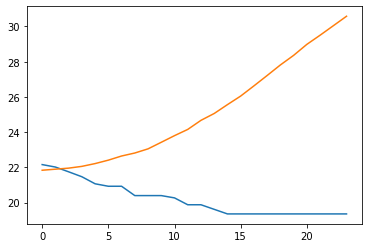

In [84]:
plt.plot(observed)
plt.plot(predicted)

In [85]:
get_nash(observed, predicted)

-42.35351068586373

In [86]:
nash_acc = 0
observeds = []
predictions = []
count=1
for i, _ in enumerate(X_test):
    
    X = X_test[i].reshape((1, n_steps_in, n_features))
    predicted = model.predict(X, verbose=0).flatten()
    observed = y_test[i]
    nash_acc += get_nash(observed, predicted)
    
    if count == 24:
        print("one more day")
        observeds += list(observed)
        predictions += list(predicted)
        count=1
    else:
        count +=1
    
print("Average nash: ", nash_acc/len(X_test))

one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day

<ipython-input-82-dddc8a739897>:11: RuntimeWarning: divide by zero encountered in double_scalars
  nash = 1 - (squared_err  / variance)


one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day
one more day

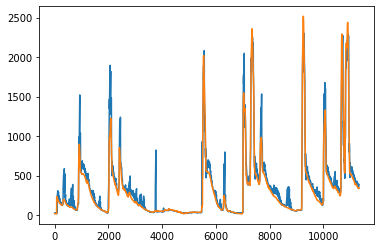

In [87]:
plt.plot(predictions)
plt.plot(observeds)

In [105]:
get_nash(np.array(observeds), np.array(predictions))

0.928203746061727

11328

In [ ]:
val_seq = [(5962, 6051), (6078, 17486), (17487, 18718), (18741, 23437)]


In [111]:
from tqdm import tqdm

In [112]:
test = np.array(dataset.iloc[18741:23437, ])
X_test, y_test = split_sequences(test, n_steps_in, n_steps_out)

observeds = []
predictions = []
count=1

test_len = len(X_test)
for i in tqdm(range(test_len)):
    
    X = X_test[i].reshape((1, n_steps_in, n_features))
    predicted = model.predict(X, verbose=0).flatten()
    observed = y_test[i]
    
    if count == 24:
        observeds += list(observed)
        predictions += list(predicted)
        count=1
    else:
        count +=1
    

100%|██████████| 4625/4625 [02:09<00:00, 35.64it/s]

Average nash:  -inf


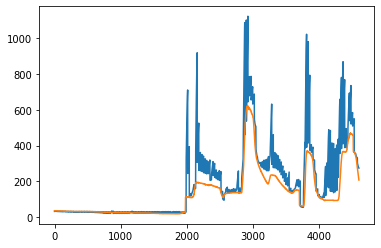

In [113]:
plt.plot(predictions)
plt.plot(observeds)

In [114]:
get_nash(predictions, observeds)

0.6558124328731828

In [117]:
len(observeds)

4608

In [116]:
len(X_test)

4625